In [191]:
import joblib
import pandas as pd

from multiobjective_gbt import MooGBTRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

import seaborn as sns
import matplotlib.pyplot as plt

#### Preprocssing MSLR Dataset

##### Convert to Pandas DataFrame

In [2]:
class Letor_Converter(object):    
    '''
    Class Converter implements parsing from original letor txt files to
    pandas data frame representation.
    '''
    
    def __init__(self, path):
        
        '''
        Arguments:
            path: path to letor txt file
        '''
        self._path = path
        
    @property
    def path(self):
        return self._path
    
    @path.setter
    def path(self, p):
        self._path = p
        
    def _load_file(self):
        '''        
        Loads and parses raw letor txt file.
        
        Return:
            letor txt file parsed to csv in raw format
        '''
        return pd.read_csv(str(self._path), sep=" ", header=None)
        
    def _drop_col(self, df):
        '''
        Drops last column, which was added in the parsing procedure due to a
        trailing white space for each sample in the text file
        
        Arguments:
            df: pandas dataframe
        Return:
            df: original df with last column dropped
        '''
        return df.drop(df.columns[-1], axis=1)
    
    def _split_colon(self, df):
        '''
        Splits the data on the colon and transforms it into a tabular format
        where columns are features and rows samples. Cells represent feature
        values per sample.
        
        Arguments:
            df: pandas dataframe object
        Return:
            df: original df with string pattern ':' removed; columns named appropriately
        '''
        for col in range(1,len(df.columns)):
            df.loc[:,col] = df.loc[:,col].apply(lambda x: str(x).split(':')[1])
        df.columns = ['rel', 'qid'] + [str(x) for x in range(1,len(df.columns)-1)] # renaming cols
        return df
    
    def convert(self):
        '''
        Performs final conversion.
        
        Return:
            fully converted pandas dataframe
        '''
        df_raw = self._load_file()
        df_drop = self._drop_col(df_raw)
        return self._split_colon(df_drop)
    
# conv = Letor_Converter("MSLR-WEB10K/Fold1/train.txt")
# df_train_fold1 = conv.convert()
# print (df_train_fold1.shape)
# df_train_fold1.head()

In [3]:
train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()

for fold in range(5):
    path = f"MSLR-WEB10K/Fold{fold + 1}/"
    train_ = Letor_Converter(f"{path}train.txt").convert()
    val_ = Letor_Converter(f"{path}vali.txt").convert()
    test_ = Letor_Converter(f"{path}test.txt").convert()
    
    print (train_.shape, val_.shape, test_.shape)
    
    train = pd.concat([train, train_])
    val = pd.concat([val, val_])    
    test = pd.concat([test, test_])    
    
    print (train.shape, val.shape, test.shape)

(723412, 138) (235259, 138) (241521, 138)
(723412, 138) (235259, 138) (241521, 138)
(716683, 138) (241521, 138) (241988, 138)
(1440095, 138) (476780, 138) (483509, 138)
(719111, 138) (241988, 138) (239093, 138)
(2159206, 138) (718768, 138) (722602, 138)
(718768, 138) (239093, 138) (242331, 138)
(2877974, 138) (957861, 138) (964933, 138)
(722602, 138) (242331, 138) (235259, 138)
(3600576, 138) (1200192, 138) (1200192, 138)


In [4]:
train.head()

,rel,qid,1,2,3,4,5,6,7,8,...,127,128,129,130,131,132,133,134,135,136
0,2,1,3,3,0,0,3,1,1,0,...,62,11089534,2,116,64034,13,3,0,0,0
1,2,1,3,0,3,0,3,1,0,1,...,54,11089534,2,124,64034,1,2,0,0,0
2,0,1,3,0,2,0,3,1,0,0.666667,...,45,3,1,124,3344,14,67,0,0,0
3,2,1,3,0,3,0,3,1,0,1,...,56,11089534,13,123,63933,1,3,0,0,0
4,1,1,3,0,3,0,3,1,0,1,...,64,5,7,256,49697,1,13,0,0,0


##### Typecasting

In [10]:
train.shape, val.shape, test.shape

((3600576, 138), (1200192, 138), (1200192, 138))

In [20]:
for col in objective_cols:
    train[col] = pd.Series(train[col], dtype='float64')
    val[col] = pd.Series(val[col], dtype='float64')    

In [13]:
train.shape, val.shape, test.shape

((3600576, 138), (1200192, 138), (1200192, 138))

In [14]:
# train.to_csv('train.csv', index=False)
# val.to_csv('val.csv', index=False)
# test.to_csv('test.csv', index=False)

In [3]:
# train = pd.read_csv('train.csv')
# val = pd.read_csv('val.csv')
# test = pd.read_csv('test.csv')
# train.shape, val.shape, test.shape

((3600576, 138), (1200192, 138), (1200192, 138))

In [5]:
train.head()

,rel,qid,1,2,3,4,5,6,7,8,...,127,128,129,130,131,132,133,134,135,136
0,2,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116.0,64034,13.0,3.0,0,0.0,0.0
1,2,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124.0,64034,1.0,2.0,0,0.0,0.0
2,0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124.0,3344,14.0,67.0,0,0.0,0.0
3,2,1,3,0,3,0,3,1.0,0.0,1.000000,...,56,11089534,13,123.0,63933,1.0,3.0,0,0.0,0.0
4,1,1,3,0,3,0,3,1.0,0.0,1.000000,...,64,5,7,256.0,49697,1.0,13.0,0,0.0,0.0


In [125]:
col_names = ['covered_query_term_number_body','covered_query_term_number_anchor',
             'covered_query_term_number_title','covered_query_term_number_url','covered_query_term_number_whole_document','covered_query_term_ratio_body','covered_query_term_ratio_anchor','covered_query_term_ratio_title','covered_query_term_ratio_url','covered_query_term_ratio_whole_document','stream_length_body','stream_length_anchor','stream_length_title','stream_length_url','stream_length_whole_document','IDF_Inverse_document_frequency__body','IDF_Inverse_document_frequency__anchor','IDF_Inverse_document_frequency__title','IDF_Inverse_document_frequency__url','IDF_Inverse_document_frequency__whole_document','sum_of_term_frequency_body','sum_of_term_frequency_anchor','sum_of_term_frequency_title','sum_of_term_frequency_url','sum_of_term_frequency_whole_document','min_of_term_frequency_body','min_of_term_frequency_anchor','min_of_term_frequency_title','min_of_term_frequency_url','min_of_term_frequency_whole_document','max_of_term_frequency_body','max_of_term_frequency_anchor','max_of_term_frequency_title','max_of_term_frequency_url','max_of_term_frequency_whole_document','mean_of_term_frequency_body','mean_of_term_frequency_anchor','mean_of_term_frequency_title','mean_of_term_frequency_url','mean_of_term_frequency_whole_document','variance_of_term_frequency_body','variance_of_term_frequency_anchor','variance_of_term_frequency_title','variance_of_term_frequency_url','variance_of_term_frequency_whole_document','sum_of_stream_length_normalized_term_frequency_body','sum_of_stream_length_normalized_term_frequency_anchor','sum_of_stream_length_normalized_term_frequency_title','sum_of_stream_length_normalized_term_frequency_url','sum_of_stream_length_normalized_term_frequency_whole_document','min_of_stream_length_normalized_term_frequency_body','min_of_stream_length_normalized_term_frequency_anchor','min_of_stream_length_normalized_term_frequency_title','min_of_stream_length_normalized_term_frequency_url','min_of_stream_length_normalized_term_frequency_whole_document','max_of_stream_length_normalized_term_frequency_body','max_of_stream_length_normalized_term_frequency_anchor','max_of_stream_length_normalized_term_frequency_title','max_of_stream_length_normalized_term_frequency_url','max_of_stream_length_normalized_term_frequency_whole_document','mean_of_stream_length_normalized_term_frequency_body','mean_of_stream_length_normalized_term_frequency_anchor','mean_of_stream_length_normalized_term_frequency_title','mean_of_stream_length_normalized_term_frequency_url','mean_of_stream_length_normalized_term_frequency_whole_document','variance_of_stream_length_normalized_term_frequency_body','variance_of_stream_length_normalized_term_frequency_anchor','variance_of_stream_length_normalized_term_frequency_title','variance_of_stream_length_normalized_term_frequency_url','variance_of_stream_length_normalized_term_frequency_whole_document','sum_of_tf_idf_body','sum_of_tf_idf_anchor','sum_of_tf_idf_title','sum_of_tf_idf_url','sum_of_tf_idf_whole_document','min_of_tf_idf_body','min_of_tf_idf_anchor','min_of_tf_idf_title','min_of_tf_idf_url','min_of_tf_idf_whole_document','max_of_tf_idf_body','max_of_tf_idf_anchor','max_of_tf_idf_title','max_of_tf_idf_url','max_of_tf_idf_whole_document','mean_of_tf_idf_body','mean_of_tf_idf_anchor','mean_of_tf_idf_title','mean_of_tf_idf_url','mean_of_tf_idf_whole_document','variance_of_tf_idf_body','variance_of_tf_idf_anchor','variance_of_tf_idf_title','variance_of_tf_idf_url','variance_of_tf_idf_whole_document','boolean_model_body','boolean_model_anchor','boolean_model_title','boolean_model_url','boolean_model_whole_document','vector_space_model_body','vector_space_model_anchor','vector_space_model_title','vector_space_model_url','vector_space_model_whole_document','BM25_body','BM25_anchor','BM25_title','BM25_url','BM25_whole_document','LMIR_ABS_body','LMIR_ABS_anchor','LMIR_ABS_title','LMIR_ABS_url','LMIR_ABS_whole_document','LMIR_DIR_body','LMIR_DIR_anchor','LMIR_DIR_title','LMIR_DIR_url','LMIR_DIR_whole_document','LMIR_JM_body','LMIR_JM_anchor','LMIR_JM_title','LMIR_JM_url','LMIR_JM_whole_document','Number_of_slash_in_URL_','Length_of_URL_','Inlink_number_','Outlink_number_','PageRank_','SiteRank','QualityScore','QualityScore2','Query-url_click_count','url_click_count','url_dwell_time']
len(col_names)

136

In [126]:
all_cols = ['rel', 'quid']
all_cols.extend(col_names)
len(all_cols)

138

In [127]:
train.columns = all_cols
val.columns = all_cols
test.columns = all_cols

In [128]:
train['rel'].value_counts()

0    1872789
1    1158840
2     478353
3      63951
4      26643
Name: rel, dtype: int64

In [129]:
val['rel'].value_counts()

0    624263
1    386280
2    159451
3     21317
4      8881
Name: rel, dtype: int64

In [130]:
test['rel'].value_counts()

0    624263
1    386280
2    159451
3     21317
4      8881
Name: rel, dtype: int64

##### Undersampling Training/Validation Data

In [131]:
train_sample = train.groupby(['rel']).apply(lambda grp: grp.sample(n=26643)).reset_index(level=[0, 1], drop=True)
val_sample = val.groupby(['rel']).apply(lambda grp: grp.sample(n=8881)).reset_index(level=[0, 1], drop=True)

train_sample.shape, val_sample.shape

((133215, 138), (44405, 138))

In [132]:
train_sample.head()

,rel,quid,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,...,Length_of_URL_,Inlink_number_,Outlink_number_,PageRank_,SiteRank,QualityScore,QualityScore2,Query-url_click_count,url_click_count,url_dwell_time
0,0,12895,1,0,1,0,1,0.500000,0.0,0.500000,...,35,21,5,575.0,65535,6.0,14.0,0,0.0,0.000000
1,0,2776,1,0,1,0,1,0.500000,0.0,0.500000,...,14,0,0,781.0,19668,1.0,7.0,0,0.0,0.000000
2,0,16933,1,0,1,0,1,1.000000,0.0,1.000000,...,34,5,0,9867.0,7509,11.0,9.0,0,0.0,0.000000
3,0,17494,1,0,1,1,1,1.000000,0.0,1.000000,...,21,0,0,60436.0,25489,15.0,7.0,0,18.0,104.116667
4,0,25954,2,0,2,0,2,0.666667,0.0,0.666667,...,37,23,0,11992.0,1688,1.0,7.0,0,0.0,0.000000


In [133]:
train_sample['rel'].value_counts()

0    26643
1    26643
2    26643
3    26643
4    26643
Name: rel, dtype: int64

In [134]:
val_sample['rel'].value_counts()

0    8881
1    8881
2    8881
3    8881
4    8881
Name: rel, dtype: int64

In [135]:
train_sample.shape, val_sample.shape

((133215, 138), (44405, 138))

##### Transforming sub-objectives to same scale as primary objective(0 to 4)

In [136]:
col_names[131], col_names[132], col_names[129], col_names[134], col_names[135]

('QualityScore',
 'QualityScore2',
 'PageRank_',
 'url_click_count',
 'url_dwell_time')

In [137]:
# QualityScore (QS), QualityScore2 (QS2), PageRank (PR), UrlClick (UC) and UrlDwellTime (UDT)
objective_cols = ['QualityScore', 'QualityScore2',\
                  'PageRank_', 'url_click_count', 'url_dwell_time']

In [138]:
def normalize_objectives(feature, a, b):
    maxi = feature.max()
    mini = feature.min()
    norm_feature = ( (b - a) * (feature - mini) / (maxi - mini) ) + a
    return norm_feature

In [139]:
for col in objective_cols:
    train_sample[col] = normalize_objectives(train_sample[col], 0, 4)
    val_sample[col] = normalize_objectives(val_sample[col], 0, 4)

In [140]:
train_sample.head()

,rel,quid,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,...,Length_of_URL_,Inlink_number_,Outlink_number_,PageRank_,SiteRank,QualityScore,QualityScore2,Query-url_click_count,url_click_count,url_dwell_time
0,0,12895,1,0,1,0,1,0.500000,0.0,0.500000,...,35,21,5,0.028551,65535,0.079051,0.220472,0,0.000000,0.000000e+00
1,0,2776,1,0,1,0,1,0.500000,0.0,0.500000,...,14,0,0,0.041146,19668,0.000000,0.110236,0,0.000000,0.000000e+00
2,0,16933,1,0,1,0,1,1.000000,0.0,1.000000,...,34,5,0,0.596644,7509,0.158103,0.141732,0,0.000000,0.000000e+00
3,0,17494,1,0,1,1,1,1.000000,0.0,1.000000,...,21,0,0,3.688320,25489,0.221344,0.110236,0,0.000026,5.017671e-07
4,0,25954,2,0,2,0,2,0.666667,0.0,0.666667,...,37,23,0,0.726561,1688,0.000000,0.110236,0,0.000000,0.000000e+00


In [141]:
val_sample.head()

,rel,quid,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,...,Length_of_URL_,Inlink_number_,Outlink_number_,PageRank_,SiteRank,QualityScore,QualityScore2,Query-url_click_count,url_click_count,url_dwell_time
0,0,3343,6,0,4,1,6,1.0,0.0,0.666667,...,54,0,0,0.094751,56219,0.000000,0.031873,0,0.000000,0.000000e+00
1,0,28036,0,0,0,1,1,0.0,0.0,0.000000,...,24,0,0,0.003301,26887,0.000000,0.446215,0,0.000000,0.000000e+00
2,0,1477,0,0,0,0,0,0.0,0.0,0.000000,...,19,0,0,2.302193,4708,0.505929,0.191235,0,0.000000,0.000000e+00
3,0,26605,3,0,1,0,3,1.0,0.0,0.333333,...,32,3,1,0.007458,26536,1.359684,2.629482,0,0.000004,5.166667e-08
4,0,7,3,0,0,0,3,1.0,0.0,0.000000,...,30,106067,0,3.879514,51486,0.000000,0.047809,0,0.000013,1.132917e-07


#### Run Unconstrained GBT Regressor

In [142]:
features = train_sample.columns[2:]
target = 'rel'
len(features)

136

In [152]:
unconstrained_gbt = MooGBTRegressor(
                        loss='ls',
                        verbose=10,
                        random_state=2021
)

unconstrained_gbt.fit(train_sample[features].values, train_sample[target].values)

      Iter       Train Loss   Remaining Time 
         1           1.9426            3.35m
         2           1.8955            3.38m
         3           1.8545            3.26m
         4           1.8119            3.16m
         5           1.7794            3.09m
         6           1.7470            3.03m
         7           1.7202            2.98m
         8           1.6970            2.93m
         9           1.6746            2.89m
        10           1.6520            2.85m
        11           1.6353            2.82m
        12           1.6186            2.78m
        13           1.6003            2.74m
        14           1.5830            2.71m
        15           1.5705            2.67m
        16           1.5574            2.64m
        17           1.5458            2.61m
        18           1.5328            2.57m
        19           1.5206            2.54m
        20           1.5126            2.51m
        21           1.5039            2.47m
        2

MooGBTRegressor(alpha=0.9, ccp_alpha=0.0, constraints=[],
                criterion='friedman_mse', init=None, learning_rate=0.1,
                loss='ls', max_depth=3, max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100,
                n_iter_no_change=None, random_state=2021, subsample=1.0,
                tol=0.0001, validation_fraction=0.1, verbose=10,
                warm_start=False)

In [153]:
# save
joblib.dump(unconstrained_gbt, "unconstrained_gbt.pkl") 

['unconstrained_gbt.pkl']

In [33]:
# unconstrained_gbt = joblib.load("unconstrained_gbt.pkl")

In [159]:
def evaluate_results(y_pred, y_true):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    n = y_pred.shape[0]
    k = len(features)
    adj_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))
    
    print (f"Mean Absolute Error - {mae}")    
    print(f"Mean Squared Error - {mse}")
    print(f"Root Mean Squared Error - {rmse}")
    print (f"r2 - {r2}")
    print (f"adjusted r2 - {adj_r2}")

In [160]:
unconstrained_gbt.feature_importances_.shape

(136,)

In [161]:
fi = pd.DataFrame()
fi['feature'] = features
fi['imp'] = unconstrained_gbt.feature_importances_
fi.sort_values('imp', ascending=False, inplace=True)
fi['imp'] = fi['imp']/fi['imp'].sum() * 100
fi.head(10)

,feature,imp
126,Length_of_URL_,12.386268
130,SiteRank,8.836088
125,Number_of_slash_in_URL_,8.632618
129,PageRank_,7.608090
133,Query-url_click_count,6.712150
122,LMIR_JM_title,5.629967
10,stream_length_body,5.620204
107,BM25_title,4.495601
14,stream_length_whole_document,4.451666
128,Outlink_number_,3.804741


In [162]:
y_pred_train = unconstrained_gbt.predict(train_sample[features])
evaluate_results(y_pred_train, train_sample[target])

Mean Absolute Error - 0.9473443390511643
Mean Squared Error - 1.2909994848217443
Root Mean Squared Error - 1.1362215826245092
r2 - 0.35450025758912784
adjusted r2 - 0.35384058457805256


In [163]:
y_pred_val = unconstrained_gbt.predict(val_sample[features])
evaluate_results(y_pred_val, val_sample[target])

Mean Absolute Error - 0.9464884341875269
Mean Squared Error - 1.2940896458083606
Root Mean Squared Error - 1.1375806106858364
r2 - 0.3529551770958197
adjusted r2 - 0.3509673281775273


In [164]:
objective_cols

['QualityScore',
 'QualityScore2',
 'PageRank_',
 'url_click_count',
 'url_dwell_time']

In [172]:
for c in objective_cols:
    print (f"{mean_squared_error(y_pred_val, val_sample[c])}")

3.7423931825914036
3.9194414852311503
2.031830440012366
4.573200403918164
4.582939639775838


In [169]:
for c in objective_cols:
    print (f"{c}, MSE - {mean_squared_error(y_pred_train, train_sample[c])}")

QualityScore, MSE - 3.714828734443458
QualityScore2, MSE - 3.8420284625259913
PageRank_, MSE - 2.0261372300869214
url_click_count, MSE - 4.541796817002684
url_dwell_time, MSE - 4.550247139757993


In [166]:
for c in objective_cols:
    print (f"{c}, MSE - {mean_squared_error(y_pred_val, val_sample[c])}")

QualityScore, MSE - 3.7423931825914036
QualityScore2, MSE - 3.9194414852311503
PageRank_, MSE - 2.031830440012366
url_click_count, MSE - 4.573200403918164
url_dwell_time, MSE - 4.582939639775838


In [167]:
for c in objective_cols:
    print (f"{c}, RMSE - {math.sqrt(mean_squared_error(y_pred_val, val_sample[c]))}")

QualityScore, RMSE - 1.9345266042604334
QualityScore2, RMSE - 1.9797579360192372
PageRank_, RMSE - 1.425422898655822
url_click_count, RMSE - 2.1385042445406004
url_dwell_time, RMSE - 2.1407801474639654


#### Constrained Regressor

In [175]:
y_cols = ['rel']
y_cols.extend(objective_cols)
y_cols

['rel',
 'QualityScore',
 'QualityScore2',
 'PageRank_',
 'url_click_count',
 'url_dwell_time']

In [176]:
mu = 1

In [183]:
unconstrained_gbt = MooGBTRegressor(
                        loss='ls',
                        n_estimators=100,
                        verbose=10,
                        random_state=2021,
                        constraints=[
                            {"mu":mu, "b":3},
                            {"mu":mu, "b":3},
                            {"mu":mu, "b":1.5},
                            {"mu":mu, "b":4},
                            {"mu":mu, "b":4}
                        ]
)

unconstrained_gbt.fit(train_sample[features].values, train_sample[y_cols].values)

      Iter       Train Loss   Remaining Time 
         1           1.9426            3.21m
         2           1.8613            3.17m
         3           1.8428            3.13m
         4           1.8057            3.07m
         5           1.7732            3.00m
         6           1.7404            2.95m
         7           1.7128            2.90m
         8           1.6944            2.86m
         9           1.6768            2.82m
        10           1.6546            2.79m
        11           1.6349            2.76m
        12           1.6237            2.72m
        13           1.6129            2.69m
        14           1.5956            2.66m
        15           1.5831            2.62m
        16           1.5744            2.60m
        17           1.5672            2.57m
        18           1.5523            2.53m
        19           1.5426            2.50m
        20           1.5365            2.47m
        21           1.5313            2.44m
        2

MooGBTRegressor(alpha=0.9, ccp_alpha=0.0,
                constraints=[{'alpha': 0, 'b': 3, 'mu': 1},
                             {'alpha': 0.2122619550670084, 'b': 3, 'mu': 1},
                             {'alpha': 0.17246325604719637, 'b': 1.5, 'mu': 1},
                             {'alpha': 0, 'b': 4, 'mu': 1},
                             {'alpha': 0, 'b': 4, 'mu': 1}],
                criterion='friedman_mse', init=None, learning_rate=0.1,
                loss='ls', max_depth=3, max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100,
                n_iter_no_change=None, random_state=2021, subsample=1.0,
                tol=0.0001, validation_fraction=0.1, verbose=10,
                warm_start=False)

In [185]:
# return a Pandas dataframe with loss values of objectives wrt boosting iteration
losses = unconstrained_gbt.loss_.get_losses()
losses.head()

,n_estimators,primary_objective,sub_objective_1,sub_objective_2,sub_objective_3,sub_objective_4,sub_objective_5
0,0,1.942555,3.212475,3.144707,2.425255,3.998334,4.002935
1,1,1.861258,2.902729,2.860118,1.877241,3.617932,3.623202
2,2,1.842809,2.897841,2.876034,1.395293,3.574403,3.580581
3,3,1.805718,2.947334,2.927003,1.403212,3.634694,3.640918
4,4,1.773215,2.989910,2.974469,1.410341,3.691874,3.698181


In [186]:
losses.tail(1)

,n_estimators,primary_objective,sub_objective_1,sub_objective_2,sub_objective_3,sub_objective_4,sub_objective_5
99,99,1.37914,2.980079,3.078888,1.552241,3.695473,3.703249


In [187]:
y_pred_val = unconstrained_gbt.predict(val_sample[features])

In [188]:
for c in y_cols:
    print (f"{mean_squared_error(y_pred_val, val_sample[c])}")

1.3813816279960351
3.000479537645039
3.1433014840634153
1.5504321353797184
3.7202936923105563
3.7291793889825406


In [189]:
for c in y_cols:
    print (f"{c}, {mean_squared_error(y_pred_val, val_sample[c])}")

rel, 1.3813816279960351
QualityScore, 3.000479537645039
QualityScore2, 3.1433014840634153
PageRank_, 1.5504321353797184
url_click_count, 3.7202936923105563
url_dwell_time, 3.7291793889825406


In [198]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["font.size"] = "20"
plt.rcParams["legend.fontsize"] = 12

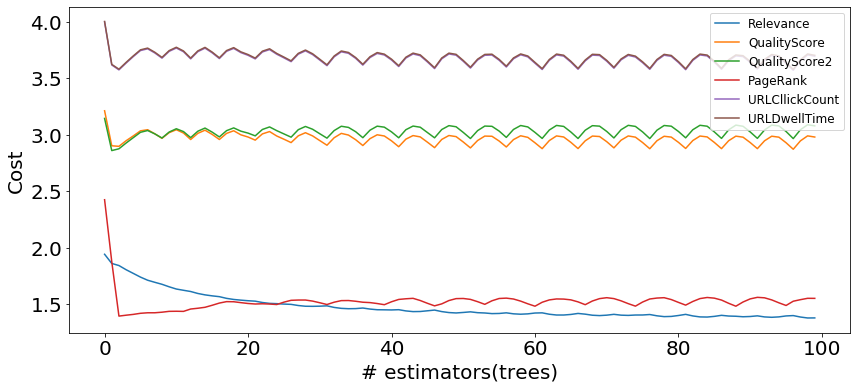

In [199]:
sns.lineplot(data=losses, x='n_estimators', y='primary_objective', label=f'Relevance')
sns.lineplot(data=losses, x='n_estimators', y='sub_objective_1', label='QualityScore')
sns.lineplot(data=losses, x='n_estimators', y='sub_objective_2', label='QualityScore2')
sns.lineplot(data=losses, x='n_estimators', y='sub_objective_3', label='PageRank')
sns.lineplot(data=losses, x='n_estimators', y='sub_objective_4', label='URLCllickCount')
sns.lineplot(data=losses, x='n_estimators', y='sub_objective_5', label='URLDwellTime')

plt.xlabel("# estimators(trees)")
plt.ylabel("Cost")
plt.legend(loc = "upper right")

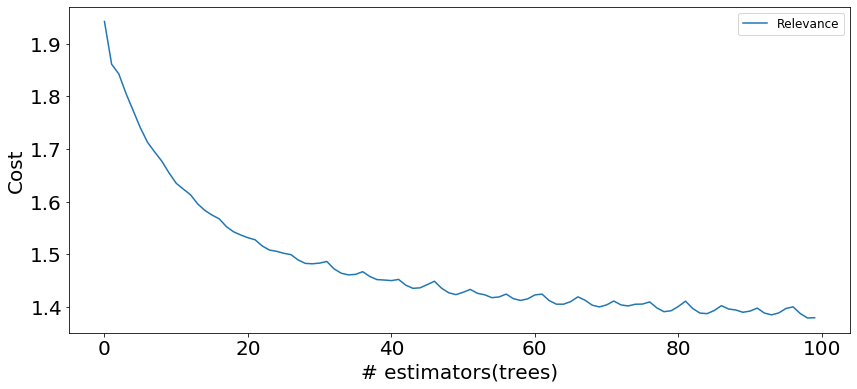

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=losses, x='n_estimators', y='primary_objective', label=f'Relevance')

plt.xlabel("# estimators(trees)")
plt.ylabel("Cost")
plt.legend(loc = "upper right")